In [1]:
pip list

Package                   Version
------------------------- --------------
anyio                     4.9.0
argon2-cffi               25.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.5
attrs                     25.3.0
babel                     2.17.0
beautifulsoup4            4.13.4
bleach                    6.2.0
certifi                   2025.6.15
cffi                      1.17.1
charset-normalizer        3.4.2
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.2
cycler                    0.12.1
debugpy                   1.8.14
decorator                 5.2.1
defusedxml                0.7.1
executing                 2.2.0
fastjsonschema            2.21.1
fonttools                 4.58.4
fqdn                      1.5.1
h11                       0.16.0
httpcore                  1.0.9
httpx                     0.28.1
idna                      3.10
ipykernel     

# Step 1 : Load & Visualize the Data

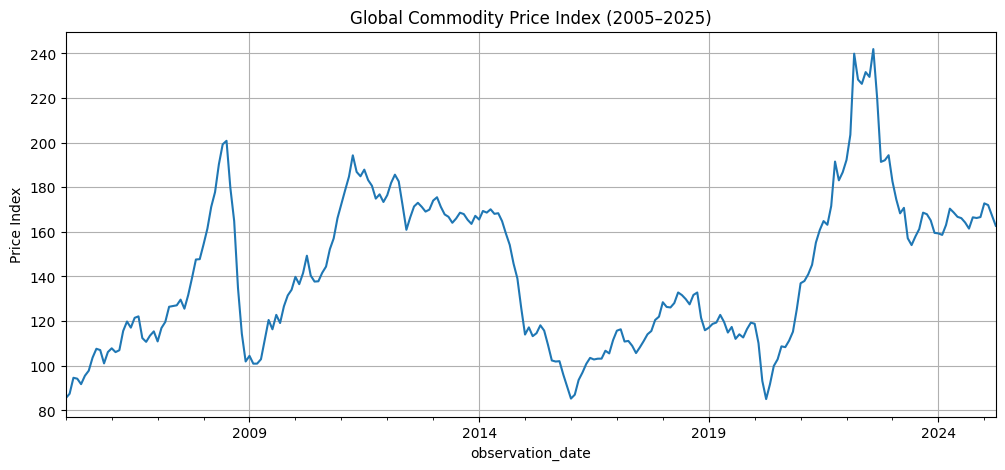

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Global Price Index Data.csv", parse_dates=['observation_date'])
df.set_index('observation_date', inplace=True)
df.rename(columns={'PALLFNFINDEXM': 'Price'}, inplace=True)

# Plot the original time series
df['Price'].plot(figsize=(12, 5), title='Global Commodity Price Index (2005–2025)')
plt.ylabel('Price Index')
plt.grid()
plt.show()

# Step 2. Split Data into Train and Test

In [3]:
# Train until Dec 2023
train = df[:'2023-12']

# Test from Jan 2024 to Apr 2025
test = df['2024-01':]

# Step 3. Train the ARIMA Model

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(p,d,q)
model = ARIMA(train['Price'], order=(1, 1, 1))  # Change to your (p,d,q)
model_fit = model.fit()
print(model_fit.summary())


n_test = len(test)

forecast = model_fit.forecast(steps=n_test)
forecast.index = test.index  # Match test index


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  228
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -751.827
Date:                Fri, 27 Jun 2025   AIC                           1509.654
Time:                        19:03:34   BIC                           1519.929
Sample:                    01-01-2005   HQIC                          1513.800
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4188      0.142      2.959      0.003       0.141       0.696
ma.L1         -0.0676      0.158     -0.428      0.669      -0.377       0.242
sigma2        44.0599      2.317     19.016      0.0

C:\Users\Sow\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Sow\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Sow\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# Step 4. Plot Forecast vs Actual

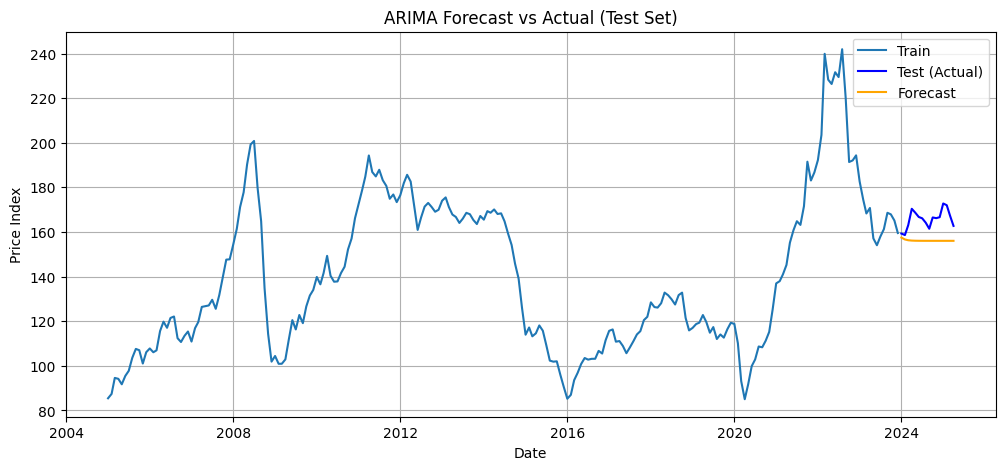

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test (Actual)', color='blue')
plt.plot(forecast, label='Forecast', color='orange')
plt.title('ARIMA Forecast vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price Index')
plt.legend()
plt.grid()
plt.show()


# Step 5: Forecast Evaluation Metrics for ARIMA

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test.values - forecast.values) / test.values)) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE:  9.61
RMSE: 10.49
MAPE: 5.74%


# Step 6: Check for Stationarity (ADF Test)

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Price'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.722195830172219
p-value: 0.07027554288111867


# Step 7: Differencing to Achieve Stationarity

In [8]:
df_diff = df['Price'].diff().dropna()

# ADF test after differencing
result_diff = adfuller(df_diff)
print(f'ADF after differencing: {result_diff[0]}')
print(f'p-value: {result_diff[1]}')


ADF after differencing: -5.855117369011361
p-value: 3.5148378021437236e-07


# Step 8:  Identify ARIMA Parameters (p, d, q) via ACF & PACF

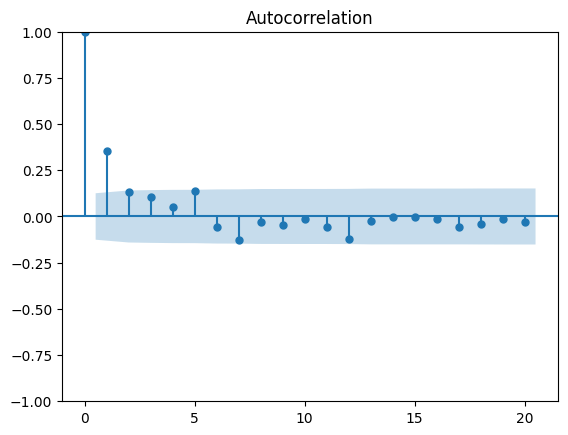

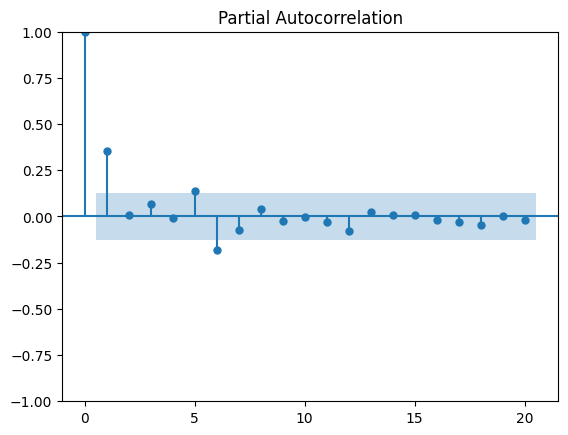

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_diff, lags=20)
plot_pacf(df_diff, lags=20)
plt.show()


# Step 9: Generate Future Dates(May 2025 - Dec 2026)

In [10]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods= 20, freq = 'MS')

# Step 10: Fit ARIMA Model

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Refit ARIMA model on all data till April 2025
model_full = ARIMA(df['Price'], order=(1, 1, 1))  # use your chosen (p,d,q)
model_fit_full = model_full.fit()

print(model_fit_full.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  244
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -798.966
Date:                Fri, 27 Jun 2025   AIC                           1603.931
Time:                        19:03:42   BIC                           1614.411
Sample:                    01-01-2005   HQIC                          1608.152
                         - 04-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3961      0.136      2.918      0.004       0.130       0.662
ma.L1         -0.0450      0.151     -0.298      0.766      -0.341       0.251
sigma2        41.9816      2.098     20.008      0.0

C:\Users\Sow\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Sow\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Sow\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# Step 11: Forecast Next 20 Months Using ARIMA

In [12]:
future_forecast = model_fit_full.forecast(steps=20)
future_forecast.index = future_dates  # Assign the new future index


# Step 12: Plot ARIMA Forecast

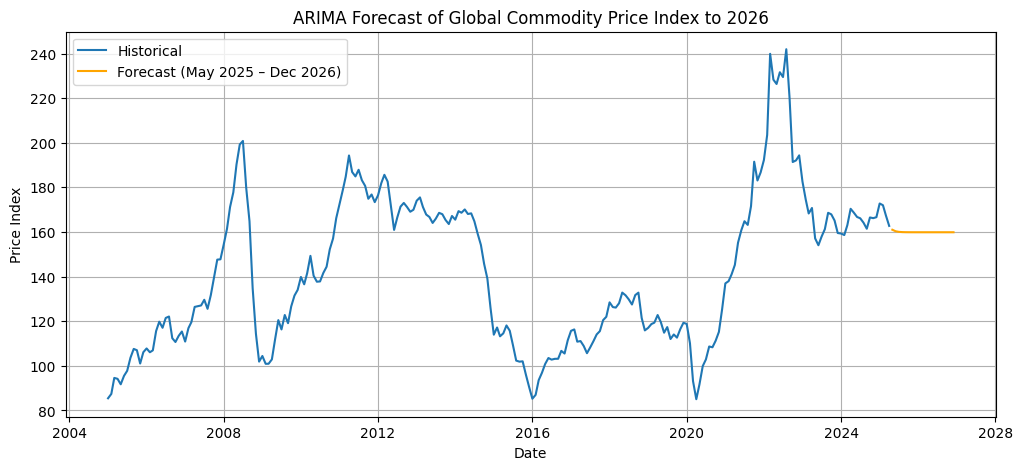

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(df['Price'], label='Historical')
plt.plot(future_forecast, label='Forecast (May 2025 – Dec 2026)', color='orange')
plt.title('ARIMA Forecast of Global Commodity Price Index to 2026')
plt.xlabel('Date')
plt.ylabel('Price Index')
plt.legend()
plt.grid()
plt.show()

# Step 13:  Fit Seasonal ARIMA (SARIMA) Model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(df['Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

print(sarima_fit.summary())


C:\Users\Sow\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Sow\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  244
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -779.563
Date:                            Fri, 27 Jun 2025   AIC                           1569.125
Time:                                    19:04:00   BIC                           1586.337
Sample:                                01-01-2005   HQIC                          1576.068
                                     - 04-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4161      0.154      2.706      0.007       0.115       0.717
ma.L1         -0.0792      0.170   

# Step 14: Forecast with SARIMA and Confidence Intervals

In [15]:
sarima_forecast_obj = sarima_fit.get_forecast(steps=20)
sarima_mean = sarima_forecast_obj.predicted_mean
sarima_conf_int = sarima_forecast_obj.conf_int()

sarima_mean.index = future_dates
sarima_conf_int.index = future_dates


# Step 15:Plot SARIMA Forecast with Confidence Intervals

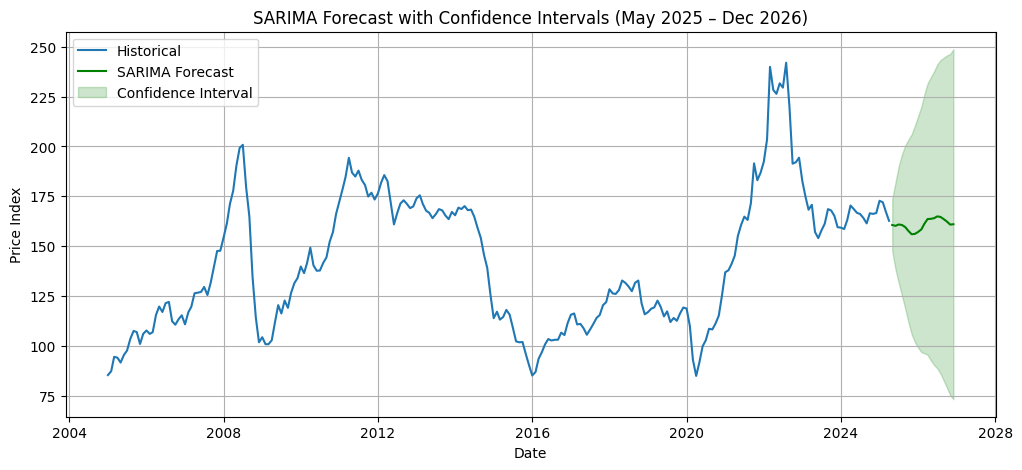

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(df['Price'], label='Historical')
plt.plot(sarima_mean, label='SARIMA Forecast', color='green')
plt.fill_between(sarima_conf_int.index,
                 sarima_conf_int.iloc[:, 0],
                 sarima_conf_int.iloc[:, 1],
                 color='green', alpha=0.2, label='Confidence Interval')
plt.title('SARIMA Forecast with Confidence Intervals (May 2025 – Dec 2026)')
plt.xlabel('Date')
plt.ylabel('Price Index')
plt.legend()
plt.grid()
plt.show()


In [18]:
!pip install openpyxl


   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]



In [19]:
# Combine forecasted values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecast': sarima_mean,
    'Lower CI': sarima_conf_int.iloc[:, 0],
    'Upper CI': sarima_conf_int.iloc[:, 1]
})

# Export to Excel
forecast_df.to_excel("SARIMA_Global_Price_Forecast_2025_2026.xlsx")
